In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from tensorflow.keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import matplotlib.patches as patches
import keras
### PLOTING ###
class PlotLosses(keras.callbacks.Callback):
    def __init__(self, plot_interval=1):
        self.plot_interval = plot_interval
    
    def on_train_begin(self, logs={}):
        print('Begin training')
        self.i = 0
        self.x = []
        self.total_losses = {}
        self.acc = {}
        self.abserrors = {}
        self.confidences = {}
        self.cat_output_loss = {}
        self.bb_loss = {}
        self.ious = {}
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        print(logs)
        for k,v in logs.items():
            if k in ['loss', 'val_loss']:
                if k not in self.total_losses:
                    self.total_losses[k] = []
                self.total_losses[k].append(v)
            elif 'confidence' in k:
                if k not in self.confidences:
                    self.confidences[k] = []
                self.confidences[k].append(v)
            elif 'category_output_loss' in k:
                if k not in self.cat_output_loss:
                    self.cat_output_loss[k] = []
                self.cat_output_loss[k].append(v)
            elif 'bounding_box_loss' in k:
                if k not in self.bb_loss:
                    self.bb_loss[k] = []
                self.bb_loss[k].append(v)
            elif 'acc' in k:
                if k not in self.acc:
                    self.acc[k] = []
                self.acc[k].append(v)
            elif 'error' in k:
                if k not in self.abserrors:
                    self.abserrors[k] = []
                self.abserrors[k].append(v)
            elif 'iou' in k:
                if k not in self.ious:
                    self.ious[k] = []
                self.ious[k].append(v)
                
        self.logs.append(logs)
        self.x.append(self.i)
        self.i += 1
        if (epoch%self.plot_interval==0):
            clear_output(wait=True)
            to_plot = [self.confidences, self.total_losses, self.cat_output_loss, self.bb_loss, self.abserrors, self.acc, self.ious]
            not_empty = []
            subplots = 0
            for pl in to_plot:
                subplots = subplots + 1*(len(pl)>0)
                if len(pl) > 0:
                    not_empty.append(pl)
            rows = int(np.ceil(subplots / 2))
            f, axs = plt.subplots(rows, 2, sharex=True, figsize=(20,5*rows))
            axs = axs.flatten()
            for i, ne in enumerate(not_empty):
                for k,v in ne.items():
                    if 'val' in k:
                        axs[i].plot(self.x, v, label=k, ls='-.', color='b')
                    else:
                        axs[i].plot(self.x, v, label=k, color='r')        
                    
                axs[i].legend()
                axs[i].grid()
            plt.show()
            
def getBB_area(bb):
    IntersectionArea = (bb[:,2] - bb[:,0])*(bb[:,3] - bb[:,1])
    return IntersectionArea

def getIUO(bb1, bb2, from_center_to_box = False):
    if from_center_to_box:
        bb1 = np.array([
             bb1[:,0] - bb1[:,2]/2, 
             bb1[:,1] - bb1[:,3]/2,
             bb1[:,0] + bb1[:,2]/2, 
             bb1[:,1] + bb1[:,3]/2,]).T
        bb2 = np.array([
             bb2[:,0] - bb2[:,2]/2, 
             bb2[:,1] - bb2[:,3]/2,
             bb2[:,0] + bb2[:,2]/2, 
             bb2[:,1] + bb2[:,3]/2,]).T

    intersection_bb = np.array([np.vstack([bb1[:,0], bb2[:,0]]).max(axis=0),
        np.vstack([bb1[:,1], bb2[:,1]]).max(axis=0),
        np.vstack([bb1[:,2], bb2[:,2]]).min(axis=0),
        np.vstack([bb1[:,3], bb2[:,3]]).min(axis=0)]).T
    no_intersec = 1*(intersection_bb[:,3]-intersection_bb[:,1]>0)*(intersection_bb[:,2]-intersection_bb[:,0]>0)
    intersection_bb = (intersection_bb.T * no_intersec).T
    IntersectionArea = no_intersec*getBB_area(intersection_bb)
    IOU = IntersectionArea/(getBB_area(bb1) + getBB_area(bb2) - IntersectionArea)
    return IOU, intersection_bb
            
def plot_batch(generator, model=None, count = 10):
    pred_bounding_boxes = None
    n_classes = generator.generator.num_classes
    if 'world' in generator.generator.class_indices:
        n_classes = n_classes - 1
    batch = next(generator)
    images_batch = batch[0]
    if generator.concat_output:
        annotations = batch[1]
    else:
        annotations = np.hstack([batch[1][0], batch[1][1]])

    if model is not None:
        predictions_ = model.predict_on_batch(images_batch)
        if generator.concat_output:
            predictions = predictions_
        else:
            predictions = np.hstack([predictions_[0], predictions_[1]])
        
        bounding_boxes_norm = predictions[:,n_classes:n_classes+4]
        pred_bounding_boxes = np.array([bounding_boxes_norm[:,0] - bounding_boxes_norm[:,2]/2, 
                                   bounding_boxes_norm[:,1] - bounding_boxes_norm[:,3]/2,
                                   bounding_boxes_norm[:,0] + bounding_boxes_norm[:,2]/2, 
                                   bounding_boxes_norm[:,1] + bounding_boxes_norm[:,3]/2,]).T
    
    bounding_boxes_norm = annotations[:,n_classes:n_classes+4]
    bounding_boxes = np.array([bounding_boxes_norm[:,0] - bounding_boxes_norm[:,2]/2, 
                               bounding_boxes_norm[:,1] - bounding_boxes_norm[:,3]/2,
                               bounding_boxes_norm[:,0] + bounding_boxes_norm[:,2]/2, 
                               bounding_boxes_norm[:,1] + bounding_boxes_norm[:,3]/2,]).T    
    for image_index in range(count):
        image_ground_truth = annotations[image_index]
        
        if model is not None:
            image_predictions = predictions[image_index]
            if generator.has_world:
                if image_ground_truth[-1] == int(np.round(image_predictions[-1])):
                    print('Confidence OK:', image_predictions[-1])
                else:
                    print('Confidence Failed:', image_predictions[-1])
            if (generator.has_world and image_ground_truth[-1] == 1) or not generator.has_world:    
                if np.argmax(image_ground_truth[:n_classes]) == np.argmax(image_predictions[:n_classes]):
                    print('Class OK:', np.argmax(image_ground_truth[:n_classes]))
                else:
                    print('Class Failed:', np.argmax(image_ground_truth[:n_classes]), np.argmax(image_predictions[:n_classes]))
                iou, _ = getIUO(image_ground_truth[n_classes:n_classes+4].reshape(1, -1), 
                             image_predictions[n_classes:n_classes+4].reshape(1, -1), from_center_to_box=True)
                print('IOU:', iou)
        else:
            print((annotations[image_index]*100).astype(int)/100)
        #if class_vector.sum() == 1:
        #    print(generator.idx_2_class_id[np.argmax(class_vector)])
        
        f, ax = plt.subplots(1,1)
        ax.imshow(images_batch[image_index])
        im_w = images_batch[image_index].shape[1]
        im_h = images_batch[image_index].shape[0]
        
        bounding_box = bounding_boxes[image_index]
        bounding_box[0] = bounding_box[0]*im_w
        bounding_box[2] = bounding_box[2]*im_w
        bounding_box[1] = bounding_box[1]*im_h
        bounding_box[3] = bounding_box[3]*im_h
        rect_gt = patches.Rectangle(bounding_box[:2],
                                        (bounding_box[2]-bounding_box[0]),
                                        (bounding_box[3]-bounding_box[1]),
                                        linewidth=2, edgecolor='r',facecolor='none')
        ax.add_patch(rect_gt)
        if pred_bounding_boxes is not None:
            bounding_box = pred_bounding_boxes[image_index]
            bounding_box[0] = bounding_box[0]*im_w
            bounding_box[2] = bounding_box[2]*im_w
            bounding_box[1] = bounding_box[1]*im_h
            bounding_box[3] = bounding_box[3]*im_h
            rect_gt = patches.Rectangle(bounding_box[:2],
                                            (bounding_box[2]-bounding_box[0]),
                                            (bounding_box[3]-bounding_box[1]),
                                            linewidth=2, edgecolor='y',facecolor='none')
            ax.add_patch(rect_gt)
        
        plt.show()
        

class GeneratorMultipleOutputs(Sequence):
    def __init__(self, annotations_dict, folder, batch_size, flip = 'no_flip', concat_output=True, get_filenames = False, target_size=(375, 500), classes=None, no_ext_idx=True, width_heigh_exp = False):
        # flip = {no_flip, always, random}
        # concat_output: classes + bounding box + confidence, todo en unico np.array
        # no_ext_idx: los keys del anotation son el filename pero sin extención (Se lo tengo que quitar entonces)
        # width_heigh_exp: La bounding box viene con witdh y height en las posiciones 3 y 4. Eso es asi en COCO
        self.width_heigh_exp = width_heigh_exp
        self.concat_output = concat_output
        self.flip = flip
        self.no_ext_idx = no_ext_idx
        self.get_filenames = get_filenames
        np.random.seed(seed=40)
        self.annotations_dict = annotations_dict
        datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=False)
        self.generator = datagen.flow_from_directory(
            classes = classes,
            directory=folder,
            target_size=target_size,
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=42
        )
        self.idx_2_class_id = {v:k for k,v in self.generator.class_indices.items()}
        self.has_world = 'world' in self.generator.class_indices
    def get_image_object_center(self):
        bboxes = []
        batch_index = self.generator.batch_index
        if self.generator.batch_index == 0:
            batch_index = self.__len__()
        batch_filenames = np.array(self.generator.filenames)[self.generator.index_array][(batch_index-1)*self.generator.batch_size:batch_index*self.generator.batch_size]
        classes = np.array(self.generator.classes)[self.generator.index_array][(batch_index-1)*self.generator.batch_size:batch_index*self.generator.batch_size]
        annot_dicts = []
        box_widths = []
        box_heights = []
        centerXs = []
        centerYs = []
        object_detected_arr = []
        for i, filename in enumerate(batch_filenames):
            class_id = self.idx_2_class_id[classes[i]] #filename.split('/')[0]
            image_idx = filename.split('/')[-1]
            if self.no_ext_idx:
                image_idx = image_idx.split('.')[0]
            if class_id == 'world':
                annot_dict = {'width':-1, 'height':-1, 'bounding_boxes':[[0,0,0,0]]}
                object_detected_arr.append(0)
            else:
                annot_dict = self.annotations_dict[class_id][image_idx]
                object_detected_arr.append(1)
                
            img_width = annot_dict['width']
            img_height = annot_dict['height']
            bounding_box = annot_dict['bounding_boxes'][0]
            if self.width_heigh_exp:
                box_width = bounding_box[2]
                box_height = bounding_box[3]
            else:
                box_width = bounding_box[2] - bounding_box[0]
                box_height = bounding_box[3] - bounding_box[1]
            centerX = (bounding_box[0]+(box_width)/2)/img_width
            centerY = (bounding_box[1]+(box_height)/2)/img_height
            box_widths.append(box_width/img_width)
            box_heights.append(box_height/img_height)
            centerXs.append(centerX)
            centerYs.append(centerY)
            annot_dicts.append(annot_dict)
        return np.array(centerXs), np.array(centerYs), np.array(box_widths), np.array(box_heights), batch_filenames, annot_dicts, np.array([object_detected_arr])
    def __len__(self):
        return int(np.ceil(self.generator.samples / float(self.generator.batch_size)))
    def __getitem__(self, idx):
        data = next(self.generator)
        centerX, centerY, width, height, batch_filenames, annot_dicts, object_detected_arr = self.get_image_object_center()
        if self.flip == 'random':
            inices_to_flip = np.random.randint(0, 2, data[0].shape[0]).nonzero()
            data[0][inices_to_flip] = np.flip(data[0][inices_to_flip], axis = 2)
            centerX[inices_to_flip] = 1 - centerX[inices_to_flip]
        elif self.flip == 'always':
            data[0][:] = np.flip(data[0][:], axis = 2)
            centerX = 1 - centerX
        if self.has_world:
            # Borro la clase world de la salida
            classes_array = np.delete(data[1], [self.generator.class_indices['world']], axis=1)
        else:
            classes_array = data[1]
        
        centerX = centerX*(object_detected_arr).reshape(-1)
        centerY = centerY*(object_detected_arr).reshape(-1)
        width = width*(object_detected_arr).reshape(-1)
        height = height*(object_detected_arr).reshape(-1)
        
        if self.concat_output:
            if self.has_world:
                output = np.hstack([classes_array, np.array([centerX, centerY, width, height]).T, object_detected_arr.T])
            else:
                output = np.hstack([classes_array, np.array([centerX, centerY, width, height]).T])
                
        else:
            if self.has_world:
                output = [classes_array, np.array([centerX, centerY, width, height]).T, object_detected_arr.T]
            else:
                output = [classes_array, np.array([centerX, centerY, width, height]).T]
        
            
        if self.get_filenames:
            return (data[0], output, batch_filenames, annot_dicts, object_detected_arr)
        else:    
            return (data[0], output)
    def __next__(self):
        return self.__getitem__(0)
    def __iter__(self):
        return self
    
    
### MODELS ###

from keras.layers import Activation, Dropout, Dense, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate, GlobalMaxPooling2D, Flatten
from keras.models import Model
from keras.constraints import max_norm

def get_conv_layer(x, filters = 32, filter_size = (3,3), pool_size=(2,2)):
    conv = Conv2D(filters, filter_size)(x)
    BN = BatchNormalization()(conv)
    act = Activation('relu')(BN)
    out = MaxPooling2D(pool_size=pool_size)(act)
    # DO1 = Dropout(0.25)(maxPool1)
    return out

def get_simple_model_common_part(input_shape=(375, 500, 3)):
    x = Input(shape=(375, 500, 3))
    l1 = get_conv_layer(x, filters = 32, filter_size = (3,3), pool_size=(2,2))
    
    l2 = get_conv_layer(l1, filters = 64, filter_size = (3,3), pool_size=(2,2))
    
    l3 = get_conv_layer(l2, filters = 128, filter_size = (3,3), pool_size=(2,2))
    
    l4 = get_conv_layer(l3, filters = 256, filter_size = (3,3), pool_size=(2,2))
    
    l5 = get_conv_layer(l4, filters = 512, filter_size = (3,3), pool_size=(2,2))

    GAP = GlobalAveragePooling2D()(l5)
    model = Model(x, GAP)
    return model

def get_simple_model(input_shape=(375, 500, 3), n_classes=5, dropout_rate_1 = 0.5, dropout_rate_2 = 0.1):
    base_model = get_simple_model_common_part(input_shape=input_shape)
    classification = Dense(n_classes, activation='softmax', name='category_output', kernel_constraint=max_norm(1.))(Dropout(dropout_rate_1)(base_model.output))
    bounding_box = Dense(4, name='bounding_box', kernel_constraint=max_norm(2.))(Dropout(dropout_rate_2)(base_model.output))
    model = Model(inputs=base_model.input, outputs=[classification, bounding_box])
    return model

from keras.applications.vgg16 import VGG16
from keras.layers import Reshape

def get_VGG16_no_dense(n_classes = 5, dropout_rate_1 = 0.5, dropout_rate_2 = 0.25, N_trainable = 19, input_shape=(375, 500,3)):
    modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    output = modelVGG16.output
    last_h = output.shape[1].value
    last_w = output.shape[2].value
    classification = Flatten(name='category_output')(Conv2D(filters = n_classes, kernel_size = (last_h, last_w), activation='softmax')(output))
    bounding_box = Flatten(name='bounding_box')(Conv2D(filters = 4, kernel_size = (last_h, last_w), activation=None)(output))
    
    model = Model(inputs=modelVGG16.input, outputs=[classification, bounding_box])
    for layer in model.layers[N_trainable:]:
        layer.trainable = True
    for layer in model.layers[:N_trainable]:
        layer.trainable = False
    return model

def get_VGG16(n_classes = 5, dropout_rate_classif = 0.5, dropout_bbox = 0.5, N_trainable = 19, BN = False):
    modelVGG16 = VGG16(include_top=False, weights='imagenet')
    if BN:
        GAP = GlobalAveragePooling2D()(BatchNormalization()(modelVGG16.output))
    else:
        GAP = GlobalAveragePooling2D()(modelVGG16.output)
        
    if dropout_rate_classif>0:
        classification = Dense(n_classes, 
                               activation='softmax', 
                               name='category_output', 
                               kernel_constraint=max_norm(1.))(Dropout(dropout_rate_classif)(GAP))
    else:
        classification = Dense(n_classes, 
                               activation='softmax', 
                               name='category_output', 
                               kernel_constraint=max_norm(1.))(GAP)
        
    if dropout_bbox>0:
        bounding_box = Dense(4, 
                             name='bounding_box', 
                             kernel_constraint=max_norm(2.))(Dropout(dropout_bbox)(GAP))
    else:
        bounding_box = Dense(4, 
                             name='bounding_box', 
                             kernel_constraint=max_norm(2.))(GAP)
        
    model = Model(inputs=modelVGG16.input, outputs=[classification, bounding_box])
    for layer in model.layers[N_trainable:]:
        layer.trainable = True
    for layer in model.layers[:N_trainable]:
        layer.trainable = False
    return model

def get_VGG16_world(n_classes = 5, input_shape=(375, 500, 3), dropout_class = 0.5, dropout_confidence = 0.5, dropout_bbox = 0.5, N_trainable = 19, activation_class='softmax', activation_bbox=None, activation_confidence='sigmoid'):
    modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    GAP = GlobalAveragePooling2D()(BatchNormalization()(modelVGG16.output))
    
    classification = Dense(n_classes, activation=activation_class, name='category_output', kernel_constraint=max_norm(1.))(Dropout(dropout_class)(GAP))
    bounding_box = Dense(4, activation=activation_bbox, name='bounding_box', kernel_constraint=max_norm(2.))(Dropout(dropout_bbox)(GAP))
    confidence = Dense(1, activation=activation_confidence, name='obj_confidence', kernel_constraint=max_norm(2.))(Dropout(dropout_confidence)(GAP))
    all_outs = Concatenate(name='concatenated_outputs')([classification, bounding_box, confidence])
    model = Model(inputs=modelVGG16.input, outputs=[all_outs])
    for layer in model.layers[N_trainable:]:
        layer.trainable = True
    for layer in model.layers[:N_trainable]:
        layer.trainable = False
    return model

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Dataset:

Hacer click en el siguiente link:

https://drive.google.com/open?id=1jP6eghPZv9-JSIOPQcQsjI0wGGmgyN4T

Agregarlo a tu drive con el icono de '+'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/My Drive/obj_det_dataset.zip" > /dev/null

# Tenemos 8 clases

In [ ]:
classes_names = {
    'n02165456': 'Vaquita de san antonio',
    'n02226429': 'grillo',
    'n01644373': 'sapo',
    'n02279972': 'mariposa',
    'n01632458': 'salamandra',
    'n02256656': 'chicharra',
    'n01774384': 'viuda negra',
    'n01770393': 'escorpion'
}

# Cargamos anotaciones de dataset

In [ ]:
#PREGUNTA 1
print(np.load("/content/challenge_dataset_v3/annotations_train.npy", allow_pickle=True))

{'n02165456': {'n02165456_8290': {'width': 500, 'height': 301, 'depth': 3, 'bounding_boxes': [[241, 122, 312, 164]]}, 'n02165456_7263': {'width': 500, 'height': 333, 'depth': 3, 'bounding_boxes': [[300, 150, 360, 219]]}, 'n02165456_18978': {'width': 500, 'height': 333, 'depth': 3, 'bounding_boxes': [[208, 139, 306, 248]]}, 'n02165456_8589': {'width': 500, 'height': 333, 'depth': 3, 'bounding_boxes': [[303, 212, 403, 308]]}, 'n02165456_10640': {'width': 500, 'height': 375, 'depth': 3, 'bounding_boxes': [[276, 212, 329, 282]]}, 'n02165456_21587': {'width': 500, 'height': 333, 'depth': 3, 'bounding_boxes': [[168, 114, 302, 202]]}, 'n02165456_247': {'width': 500, 'height': 360, 'depth': 3, 'bounding_boxes': [[209, 119, 347, 312]]}, 'n02165456_18206': {'width': 500, 'height': 367, 'depth': 3, 'bounding_boxes': [[132, 135, 210, 207]]}, 'n02165456_6788': {'width': 500, 'height': 320, 'depth': 3, 'bounding_boxes': [[274, 82, 375, 152]]}, 'n02165456_11633': {'width': 500, 'height': 333, 'depth'

In [ ]:
reduced_dataset_folder = './challenge_dataset_v3' #ubuntu con GPU

In [ ]:
! ls {reduced_dataset_folder}

annotations_test.npy  annotations_train.npy  annotations_val.npy  images


In [ ]:
# Cargar anotaciones en train y val (Colocal path)
annotations_dict_train = np.load('/content/challenge_dataset_v3/annotations_train.npy', allow_pickle=True).flat[0]
annotations_dict_val = np.load('/content/challenge_dataset_v3/annotations_val.npy', allow_pickle=True).flat[0]

In [ ]:
classes = list(annotations_dict_train.keys())
print(classes)

['n02165456', 'n02226429', 'n01644373', 'n02279972', 'n01632458', 'n02256656', 'n01774384', 'n01770393']


In [ ]:
! ls {reduced_dataset_folder + '/images/train'}

n01632458  n01770393  n02165456  n02256656  world
n01644373  n01774384  n02226429  n02279972


In [ ]:
! ls {reduced_dataset_folder + '/images/val'}

n01632458  n01770393  n02165456  n02256656  world
n01644373  n01774384  n02226429  n02279972


In [ ]:
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'

# Armamos un generador para Train y otro para Val
https://keras.io/preprocessing/image/

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
target_size=(320, 320) 
batch_size = 64 

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

train_generator = datagen_train.flow_from_directory(
    classes = classes_names,
    directory= "/content/challenge_dataset_v3/images/train",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 2400 images belonging to 8 classes.


In [ ]:
datagen_val = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
val_generator = datagen_val.flow_from_directory(
    classes = classes_names,
    directory= "/content/challenge_dataset_v3/images/val",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 480 images belonging to 8 classes.


In [ ]:
idx_2_class = {v:k for k,v in train_generator.class_indices.items()}

In [ ]:
#Respuesta 2
next(val_generator)[0].shape

(64, 320, 320, 3)

In [ ]:
next(val_generator)[1].shape

(64, 8)

In [ ]:
next(val_generator)[1][:10]

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Graficamos un Batch
(Cada vez que lo corremos trae imagenes diferentes)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
batch = next(val_generator)

Batch size, Height, Width, Depth: (64, 320, 320, 3)
Batch size, classes: (64, 8)

clase: grillo n02226429


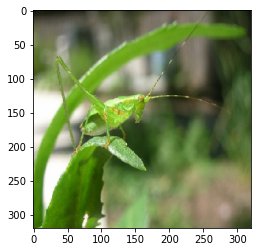

clase: viuda negra n01774384


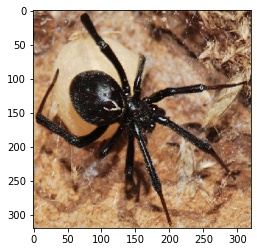

clase: sapo n01644373


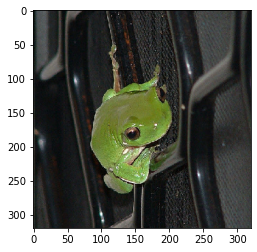

clase: mariposa n02279972


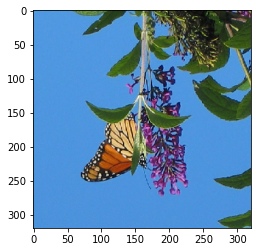

clase: mariposa n02279972


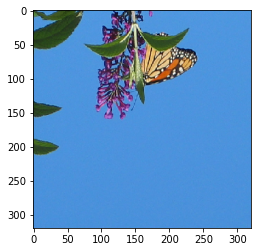

clase: salamandra n01632458


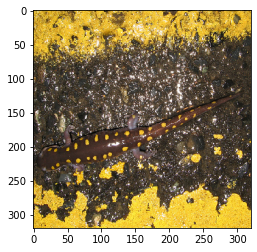

clase: salamandra n01632458


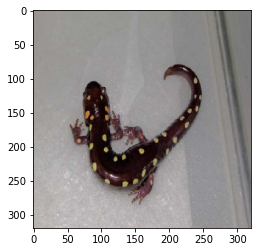

clase: salamandra n01632458


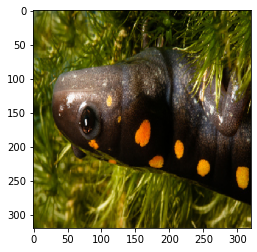

clase: chicharra n02256656


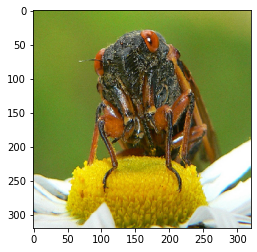

clase: salamandra n01632458


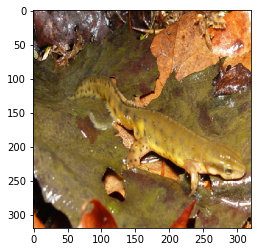

In [ ]:
batch = next(val_generator)
print('Batch size, Height, Width, Depth:', batch[0].shape)
print('Batch size, classes:', batch[1].shape)
print()
show_N=10
for i, image in enumerate(batch[0][:show_N]):
    plt.imshow(image)
    class_idx = np.argmax(batch[1][i])
    class_id = idx_2_class[class_idx]
    print('clase:', classes_names[class_id], class_id)
    plt.show()

# Armamos modelo usando tranfer learning con la VGG-16

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Activation
from keras.models import Model

In [ ]:
n_classes = len(classes)

In [ ]:
target_size

(320, 320)

In [ ]:
# El n trainable era 17 #
N_trainable = 2

modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=(320,320, 3))
flatten_output = Flatten()(modelVGG16.output)
dense_1_output = Activation('relu')(Dense(128, name = 'Dense_1')(flatten_output))
dense_2_output = Activation('relu')(Dense(128, name = 'Dense_2')(dense_1_output))

classification = Dense(n_classes, activation='softmax', name='category_output')(dense_2_output)

import tensorflow as tf

# No estoy seguro de esto 
inputs = tf.keras.Input(shape=(320,320))
x = tf.keras.layers.Dense(5, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(8, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
              
# CANTIDAD DE CAPAS ENTRENABLES
print('Primer capa entrenable:', model.layers[N_trainable].name)
for layer in model.layers[N_trainable:]:
    layer.trainable = True
for layer in model.layers[:N_trainable]:
    layer.trainable = False

Primer capa entrenable: dense_9


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 320, 320)]        0         
_________________________________________________________________
dense_8 (Dense)              (None, 320, 5)            1605      
_________________________________________________________________
dense_9 (Dense)              (None, 320, 8)            48        
Total params: 1,653
Trainable params: 48
Non-trainable params: 1,605
_________________________________________________________________


In [ ]:
# TODO #
import tensorflow as tf

from keras.callbacks import ModelCheckpoint
#from tf.keras.optimizers import Adam, rmsprop, SGD
filename = 'classif_runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_acc', save_best_only=True)

model.compile(loss=['categorical_crossentropy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])


In [ ]:
steps_per_epoch = len(train_generator)
print(steps_per_epoch)

38


In [ ]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_steps=len(val_generator),
        validation_data=val_generator, 
        callbacks = [plot_losses, checkpoint]
        )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Begin training
Epoch 1/10


ValueError: ignored

# Evaluamos el modelo luego de entrenar por 10 epochs

In [ ]:
model.load_weights('classif_runtime_best.hdf5')

In [ ]:
loss, acc = model.evaluate_generator(val_generator)
print('Val loss:', loss)
print('Val Acc:', acc)

Val loss: 0.4438866138458252
Val Acc: 0.8458333333333333


# Modelo sin capas densas (all conv network)

## Supongamos una input shape

In [ ]:
from keras.layers import Conv2D
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [ ]:
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=None)
output = modelVGG16.layers[-1].output
print(output)
last_w = output.shape[1].value
last_h = output.shape[2].value
print(last_w, last_h)

Tensor("block5_pool_4/MaxPool:0", shape=(?, ?, ?, 512), dtype=float32)
None None


In [ ]:
input_shape=(320, 320,3)
N_trainable = 17
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#modelVGG16.summary()
output = modelVGG16.layers[-1].output
print(output)
last_w = output.shape[1].value
last_h = output.shape[2].value
print(last_w, last_h)
# Notar que el shape cambia al cambiar la entrada

Tensor("block5_pool_5/MaxPool:0", shape=(?, 10, 10, 512), dtype=float32)
10 10


In [ ]:
modelVGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0     

In [ ]:
last_w, last_h = 10, 10
dense_conv = Conv2D(filters = n_classes, kernel_size = (last_w, last_h), activation='softmax', name='category_output')
classification = dense_conv(modelVGG16.output)

In [ ]:
model = Model(inputs=modelVGG16.input, outputs=classification)

In [ ]:
print('Primer capa entrenable:', model.layers[N_trainable].name)
for layer in model.layers[N_trainable:]:
    layer.trainable = True
for layer in model.layers[:N_trainable]:
    layer.trainable = False

Primer capa entrenable: block5_conv3


In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0   